# Optimisation: First example

This example shows you how to run a global optimisation with Pints.

First, we import pints:

In [1]:
import pints

Next, we need a model: any class that implements the [pints.ForwardModel interface](http://pints.readthedocs.io/en/latest/core_classes_and_methods.html#forward-model).

Usually, you'd write a class for this purpose (that wrapped around whatever simulation package you wanted to use to generate your time series data). But you could also use a pure-Python model.

In the example, we use a [logistic model](https://en.wikipedia.org/wiki/Logistic_function), provided by [Pints's toy model module](http://pints.readthedocs.io/en/latest/toy/index.html).

In [2]:
import pints.toy as toy
model = toy.LogisticModel()

This model has two parameters: A growth rate (which determines the steepness of the curve) and a carrying capacity (which determines the number the curve converges to).
For the example, we simply pick some nice values:

In [3]:
real_parameters = [0.015, 500]

Finally, we create a list of times (in a real experiment, these would be the times at which the time series was sampled)

In [4]:
import numpy as np
times = np.linspace(0, 1000, 1000)

We now have everything we need to run a simulation and generate some toy data:

In [5]:
values = model.simulate(real_parameters, times)

We can use Matplotlib (or any other plotting package) to have a look at the generated data:

In [6]:
import matplotlib.pyplot as plt

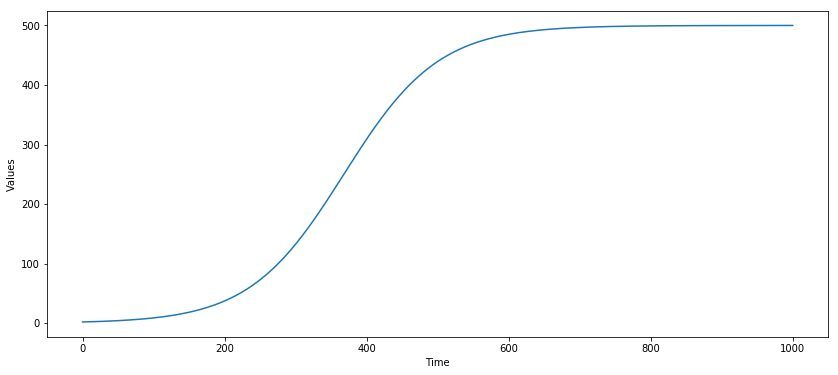

In [7]:
plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values)
plt.show()

If you like, you can make it more realistic at this point by adding some noise:

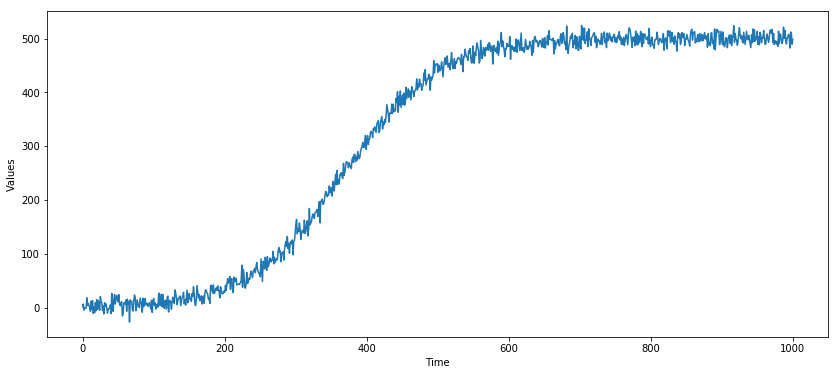

In [8]:
values += np.random.normal(size=values.shape) * 10

plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values)
plt.show()

We now set up an optimisation, to see if we can recover our original parameters from this data.

First, we define a problem (in this case a [single-valued time series fitting problem](https://pints.readthedocs.io/en/latest/core_classes_and_methods.html#pints.SingleOutputProblem)):

In [9]:
problem = pints.SingleOutputProblem(model, times, values)

We then define a [score function](http://pints.readthedocs.io/en/latest/error_measures.html) on this problem:

In [10]:
score = pints.SumOfSquaresError(problem)

A lot of real problems have physical constraints on the values the parameters can take, so in this example we add them in the form of [boundaries](http://pints.readthedocs.io/en/latest/boundaries.html):

In [11]:
boundaries = pints.RectangularBoundaries([0, 200], [1, 1000])

Finally, we define an initial position to start searching at

In [12]:
x0 = np.array([0.5, 500])

We now run an optimisation, using the [xNES](http://pints.readthedocs.io/en/latest/optimisers/xnes.html) method (although we could also have used a different global [optimiser](http://pints.readthedocs.io/en/latest/optimisers/index.html), like [CMA-ES](http://pints.readthedocs.io/en/latest/optimisers/cmaes.html) or [PSO](http://pints.readthedocs.io/en/latest/optimisers/pso.html)):

In [16]:
found_parameters, found_value = pints.optimise(
    score,
    x0,
    boundaries=boundaries,
    method=pints.XNES,
    )
print(found_parameters, found_value)

Minimising error measure
Using Exponential Natural Evolution Strategy (xNES)
Running in sequential mode.
Population size: 6
Iter. Eval. Best      Time m:s
0     6      4.08e+07   0:00.0
1     12     4.02e+07   0:00.0
2     18     4.02e+07   0:00.0
3     24     2.75e+07   0:00.0
20    126    109351.9   0:00.0
40    246    99973.39   0:00.0
60    366    99315.04   0:00.1
80    486    99310.26   0:00.1
100   606    99310.23   0:00.1
120   726    99310.23   0:00.1
140   846    99310.23   0:00.1
160   966    99310.23   0:00.1
180   1086   99310.23   0:00.1
200   1206   99310.23   0:00.1
220   1326   99310.23   0:00.2
240   1446   99310.23   0:00.2
260   1566   99310.23   0:00.2
280   1686   99310.23   0:00.2
300   1806   99310.23   0:00.2
320   1926   99310.23   0:00.2
340   2046   99310.23   0:00.2
360   2166   99310.23   0:00.3
380   2286   99310.23   0:00.3
386   2316   99310.23   0:00.3
Halting: No significant change for 200 iterations.
[1.49935562e-02 5.00784232e+02] 99310.23181257013


In our toy model example, we can compare the parameters with the known true parameters:

In [15]:
print('Score at true solution: ')
print(score(real_parameters))

print('Found solution:          True parameters:' )
for k, x in enumerate(found_parameters):
    print(pints.strfloat(x) + '    ' + pints.strfloat(real_parameters[k]))

Score at true solution: 
99587.56636132818
Found solution:          True parameters:
 1.49935561839082288e-02     1.49999999999999994e-02
 5.00784231995815503e+02     5.00000000000000000e+02


And we can also plot the score between the found solution and the true parameters.

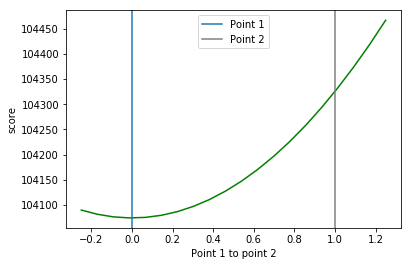

In [17]:
import pints.plot
fig, axes = pints.plot.function_between_points(score, point_1=found_parameters, point_2=real_parameters)
axes.set_ylabel('score')
plt.show()

In real life, we might compare the fit by running a simulation and comparing with the data:

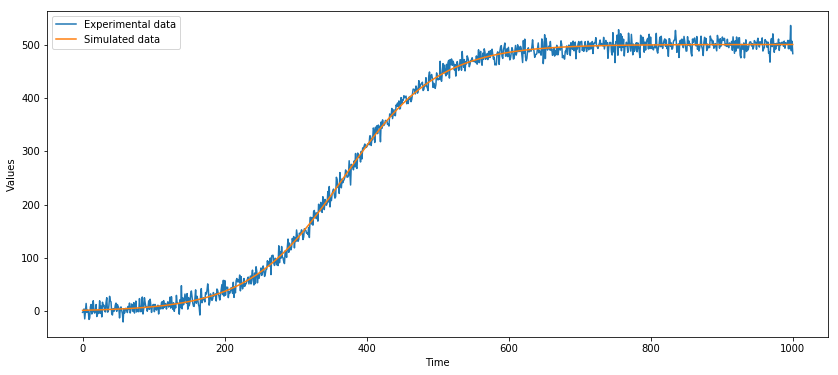

In [18]:
values2 = model.simulate(found_parameters, times)

plt.figure(figsize=(14, 6))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Experimental data')
plt.plot(times, values2, label='Simulated data')
plt.legend()
plt.show()